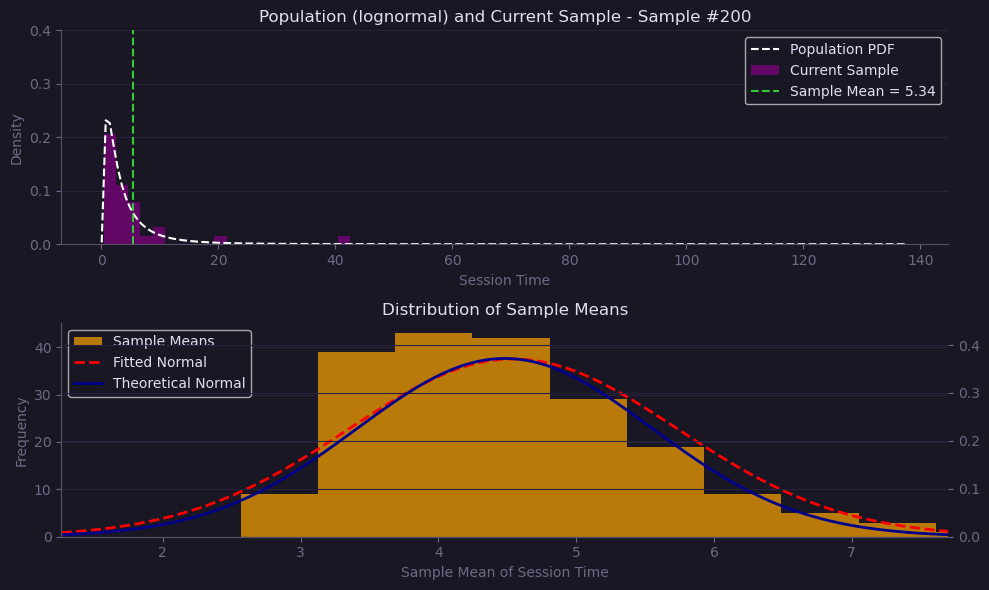

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import norm

plt.style.use("C:\\Users\\TylerKleinbauer\\.matplotlib\\stylelib\\rose-pine.mplstyle")

# Set seed for reproducibility
np.random.seed(42)

# Parameters
num_samples = 200     # Number of samples (frames)
sample_size = 30
population_size = 10000
mean_lognormal = 1.0
sigma_lognormal = 1.0

# Generate population data (for visualization)
population_data = np.random.lognormal(mean=mean_lognormal, sigma=sigma_lognormal, size=population_size)

# Compute population mean and std for the lognormal distribution
mu_pop = np.exp(mean_lognormal + 0.5 * sigma_lognormal**2)
var_pop = (np.exp(sigma_lognormal**2) - 1) * np.exp(2*mean_lognormal + sigma_lognormal**2)
std_pop = np.sqrt(var_pop)

# Theoretical distribution of the sample mean
theoretical_mean = mu_pop
theoretical_std = std_pop / np.sqrt(sample_size)

# Precompute population PDF for display
pop_min, pop_max = np.min(population_data), np.max(population_data)
x_vals_pop = np.linspace(pop_min, pop_max, 200)
pop_pdf = (1/(x_vals_pop * sigma_lognormal * np.sqrt(2*np.pi))) * \
          np.exp(-(np.log(x_vals_pop)-mean_lognormal)**2/(2*sigma_lognormal**2))

def generate_sample(n=sample_size):
    return np.random.lognormal(mean=mean_lognormal, sigma=sigma_lognormal, size=n)

sample_means = []

fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True)

# Create a twin axis for the bottom panel for the theoretical PDF
ax_bottom_pdf = ax_bottom.twinx()

# Fix x-limits for the bottom panel around the theoretical mean ± 3 std
x_min_theor = theoretical_mean - 3 * theoretical_std
x_max_theor = theoretical_mean + 3 * theoretical_std
ax_bottom.set_xlim(x_min_theor, x_max_theor)
ax_bottom_pdf.set_xlim(x_min_theor, x_max_theor)

# Compute the theoretical PDF line once
x_vals_theor = np.linspace(x_min_theor, x_max_theor, 200)
pdf_theor = norm.pdf(x_vals_theor, loc=theoretical_mean, scale=theoretical_std)
pdf_max = pdf_theor.max()
ax_bottom_pdf.set_ylim(0, pdf_max * 1.2)  # Add some margin above max PDF

def init():
    # Initialize the top plot
    ax_top.clear()
    ax_bottom.clear()
    ax_bottom_pdf.clear()

    # Top panel
    ax_top.plot(x_vals_pop, pop_pdf, linestyle='--', color='white',
                label='Population PDF')
    ax_top.set_ylim(0, 0.4)  # Fixed y-limits
    ax_top.set_title("Population (lognormal) and Current Sample")
    ax_top.set_ylabel("Density")
    ax_top.set_xlabel("Session Time")
    ax_top.legend()

    # Bottom panel
    # Plot theoretical distribution on the PDF axis (in blue)
    ax_bottom.hist([], bins=20, alpha=0.7, color='orange', 
                   label='Sample Means')
    ax_bottom.set_title("Distribution of Sample Means")
    ax_bottom.set_xlabel("Sample Mean of Session Time")
    ax_bottom.set_ylabel("Frequency")
    
    # On the PDF axis, plot the theoretical distribution line
    ax_bottom_pdf.plot(x_vals_theor, pdf_theor, linestyle='-', color='darkblue',
                       lw=2, label='Theoretical Normal')
    ax_bottom_pdf.set_ylabel("Density (Theoretical)")

    # Combine legends from both axes
    lines_1, labels_1 = ax_bottom.get_legend_handles_labels()
    lines_2, labels_2 = ax_bottom_pdf.get_legend_handles_labels()
    ax_bottom.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    return []

def update(frame):
    # Generate one sample and compute its mean
    sample = generate_sample()
    current_mean = np.mean(sample)
    sample_means.append(current_mean)

    # Clear axes for new frame (except for theoretical line on PDF axis, re-plot it)
    ax_top.clear()
    ax_bottom.clear()
    ax_bottom_pdf.clear()

    # ---- Top Panel: Population + Current Sample ----
    ax_top.plot(x_vals_pop, pop_pdf, linestyle='--', color = 'white',
                label='Population PDF')
    # Histogram of the current sample
    ax_top.hist(sample, bins=20, alpha=0.7, color='purple', 
                density=True, label='Current Sample')
    # Vertical line for sample mean
    ax_top.axvline(current_mean, color='limegreen', 
                   linestyle='--', label=f'Sample Mean = {current_mean:.2f}')
    ax_top.set_ylim(0, 0.4)  # Keep axis stable
    ax_top.set_title(f"Population (lognormal) and Current Sample - Sample #{frame+1}")
    ax_top.set_ylabel("Density")
    ax_top.set_xlabel("Session Time")
    ax_top.legend()

    # ---- Bottom Panel: Distribution of Sample Means ----
    # Histogram of sample means on main axis
    counts_means, bins_means, patches_means = ax_bottom.hist(sample_means, bins=20, alpha=0.7, color='orange', 
                                                             label='Sample Means')
    ax_bottom.set_title("Distribution of Sample Means")
    ax_bottom.set_xlabel("Sample Mean of Session Time")
    ax_bottom.set_ylabel("Frequency")
    ax_bottom.set_xlim(x_min_theor, x_max_theor)

    # Plot theoretical distribution on PDF axis
    ax_bottom_pdf.plot(x_vals_theor, pdf_theor, '-', color= 'darkblue',
                       lw=2, label='Theoretical Normal')
    ax_bottom_pdf.set_ylabel("")
    ax_bottom_pdf.set_xlim(x_min_theor, x_max_theor)
    ax_bottom_pdf.set_ylim(0, pdf_max * 1.2)

    # If we have enough sample means, overlay the fitted normal (red) on main axis
    if len(sample_means) > 1:
        mean_est = np.mean(sample_means)
        std_est = np.std(sample_means, ddof=1)
        pdf_est = norm.pdf(x_vals_theor, loc=mean_est, scale=std_est)
        # Scale PDF to match histogram scale
        # We'll convert PDF to "frequency" by multiplying by bin width and number of samples
        bin_width = bins_means[1] - bins_means[0]
        pdf_est_scaled = pdf_est * len(sample_means) * bin_width
        ax_bottom.plot(x_vals_theor, pdf_est_scaled, linestyle='--', color='red', 
                       lw=2, label='Fitted Normal')

    # Combine legends from both axes
    lines_1, labels_1 = ax_bottom.get_legend_handles_labels()
    lines_2, labels_2 = ax_bottom_pdf.get_legend_handles_labels()
    # Avoid duplicate legends if possible:
    # Theoretical Normal is always on ax_bottom_pdf, Sample Means always on ax_bottom, etc.
    # We'll merge them thoughtfully:
    combined_lines = lines_1
    combined_labels = labels_1
    for l, lab in zip(lines_2, labels_2):
        if lab not in combined_labels:
            combined_lines.append(l)
            combined_labels.append(lab)
    ax_bottom.legend(combined_lines, combined_labels, loc='upper left')

    return []

anim = FuncAnimation(fig, update, frames=num_samples, init_func=init, blit=False, interval=25)

# Save the animation as GIF
try:
    anim.save("clt_sample_means.gif", writer='imagemagick', fps=10)
except:
    from matplotlib.animation import PillowWriter
    anim.save("clt_sample_means.gif", writer=PillowWriter(fps=10))

plt.show()
